In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from tensorflow import keras
from PIL import Image

%matplotlib inline

In [18]:
EPOCHS = 10
IMG_SIZE = 224
CHANNEL = 3
BATCH_SIZE = 32

In [3]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(r"D:\data_for_ml\Sports ball classification\train",
                                                                 shuffle=True,
                                                                 image_size=(IMG_SIZE,IMG_SIZE),
                                                                 batch_size=BATCH_SIZE)

Found 7328 files belonging to 15 classes.


In [4]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(r"D:\data_for_ml\Sports ball classification\test",
                                                                 shuffle=True,
                                                                 image_size=(IMG_SIZE,IMG_SIZE),
                                                                 batch_size=BATCH_SIZE)

Found 1841 files belonging to 15 classes.


In [5]:
class_names = train_data.class_names
class_names

['american_football',
 'baseball',
 'basketball',
 'billiard_ball',
 'bowling_ball',
 'cricket_ball',
 'football',
 'golf_ball',
 'hockey_ball',
 'hockey_puck',
 'rugby_ball',
 'shuttlecock',
 'table_tennis_ball',
 'tennis_ball',
 'volleyball']

In [6]:
dataset = train_data.concatenate(test_data)
len(dataset)

287

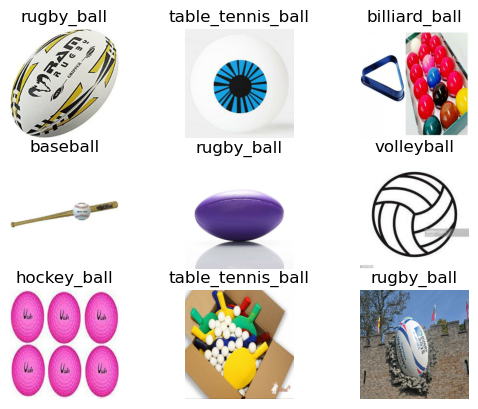

In [7]:
for images, label in dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [8]:
def create_data_batch(dataset,test_size = 0.1,train_split=0.8,val_split=0.1,shuffle=True,shuffle_size=1000):
      ds_size = len(dataset)
      if shuffle:
        dataset = dataset.shuffle(shuffle_size,seed=12)
      train_size = int(ds_size*train_split)
      val_size = int(ds_size*val_split)

      train_ds = dataset.take(train_size)
      val_ds = dataset.skip(train_size).take(val_size)
      test_ds = dataset.skip(train_size).skip(val_size)

      return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds = create_data_batch(dataset)

In [10]:
len(train_ds),len(val_ds),len(test_ds)

(229, 28, 30)

In [11]:
rescaling_resize = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Rescaling(1.0/255),
    keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)
])

In [12]:
pre_trained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
    pooling='max',
    classes=15,
    classifier_activation="softmax",
)

In [13]:
for layers in pre_trained_model.layers:
    layers.trainable=False

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
INPUT_SHAPE = (BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNEL)
OUTPUT_SHAPE = 15

pre_trained_model= tf.keras.Sequential([
    rescaling_resize,
    pre_trained_model,
    tf.keras.layers.Flatten(),
    #dense layers
    tf.keras.layers.Dense(250,activation='relu'),
    tf.keras.layers.Dense(OUTPUT_SHAPE,activation="softmax")
        
])

pre_trained_model.build(INPUT_SHAPE)

In [16]:
pre_trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (32, 1280)                0         
                                                                 
 dense (Dense)               (32, 250)                 320250    
                                                                 
 dense_1 (Dense)             (32, 15)                  3765      
                                                                 
Total params: 2,581,999
Trainable params: 324,015
Non-trainable params: 2,257,984
______________________________________

In [17]:
pre_trained_model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['acc'])

callback=tf.keras.callbacks.EarlyStopping(monitor='acc',patience=2)

In [19]:
 history = pre_trained_model.fit(train_ds,validation_data=val_ds, epochs=EPOCHS, callbacks=[callback])

Epoch 1/10
229/229 [==============================] - 271s 1s/step - loss: 1.4558 - acc: 0.6073 - val_loss: 0.7118 - val_acc: 0.7812
Epoch 2/10
229/229 [==============================] - 223s 973ms/step - loss: 0.6998 - acc: 0.7826 - val_loss: 0.5684 - val_acc: 0.8170
Epoch 3/10
229/229 [==============================] - 242s 1s/step - loss: 0.5025 - acc: 0.8414 - val_loss: 0.4574 - val_acc: 0.8638
Epoch 4/10
229/229 [==============================] - 206s 900ms/step - loss: 0.3782 - acc: 0.8824 - val_loss: 0.3205 - val_acc: 0.9018
Epoch 5/10
229/229 [==============================] - 222s 972ms/step - loss: 0.2718 - acc: 0.9130 - val_loss: 0.2384 - val_acc: 0.9442
Epoch 6/10
229/229 [==============================] - 233s 1s/step - loss: 0.1788 - acc: 0.9476 - val_loss: 0.2614 - val_acc: 0.9163
Epoch 7/10
229/229 [==============================] - 214s 936ms/step - loss: 0.1430 - acc: 0.9554 - val_loss: 0.2334 - val_acc: 0.9375
Epoch 8/10
229/229 [==============================] - 209

In [20]:
pre_trained_model.evaluate(test_ds)

30/30 [==============================] - 59s 1s/step - loss: 0.2086 - acc: 0.9513


[0.20864775776863098, 0.9513227343559265]

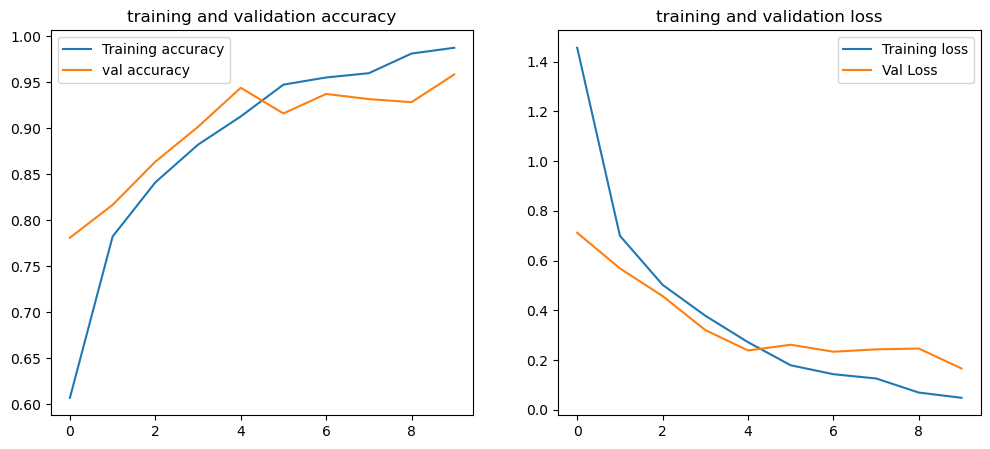

In [21]:
loss = history.history["loss"]
acc = history.history["acc"]
val_loss = history.history["val_loss"]
val_acc = history.history["val_acc"]

# Accuracy for training and val
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training accuracy")
plt.plot(range(EPOCHS),val_acc,label="val accuracy")
plt.legend()
plt.title("training and validation accuracy")

# loss for val and training
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="Training loss")
plt.plot(range(EPOCHS),val_loss,label="Val Loss")
plt.legend()
plt.title("training and validation loss");

## Test with External Image

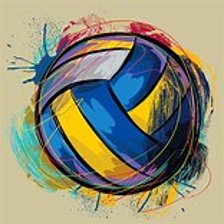

In [26]:
from PIL import Image

img = Image.open(r"D:\image for testing\vollyball.jpeg").resize((224,224))
img

In [27]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_dim = np.expand_dims(img_array, axis=0)
predicted = pre_trained_model.predict(img_dim)
print(f"predicted_image: {class_names[np.argmax(predicted)]}")

1/1 [==============================] - 0s 122ms/step
predicted_image: volleyball


In [25]:
# pre_trained_model.save("C:\\Users\\vicky\\desktop\\sample_project_1\\saved_models\\Sports_ball_prediction_v2.h5")